# Oil and Gas 

Using Colorado oil and gas data at https://cogcc.state.co.us/data2.html#/downloads to calculate scores based on 

* the number of [wells](https://cogcc.state.co.us/documents/data/downloads/gis/metadata/Oil_and_Gas_Locations_Metadata.html) , [pits](https://cogcc.state.co.us/documents/data/downloads/gis/metadata/Pits_Metadata.html), and [tank batteries](https://cogcc.state.co.us/documents/data/downloads/gis/metadata/Tank_Batteries_Metadata.html) within a buffer distance of a populated block
* the [state](https://cogcc.state.co.us/documents/about/COGIS_Help/Status_Codes.pdf) of the well (ex. not active anymore, just being drilled, etc. where the older the well is the less harmful it is currently) 

for all populated census tracts in Colorado.

__Contents:__
    
1. [Read and plot data](#read_plot)
2. [Filter out non-populated census blocks](#filter_non_pop)
3. [Create buffers around populated census blocks](#buffer)
4. [Count the # of wells, pits, tanks within buffered blocks, partitioned by facility status](#count_totals)
5. [Create oil score per buffered populated blocks (equal weights for all tanks, pits, wells, status codes for now)](#block_oil_score)
6. [Create oil score per census tract (weighted average of oil score per block by block area)](#tract_oil_score)
7. [Analysis with oil scores](#analysis)
8. [Research on weights (between tanks, pits, wells, status codes)](#weights_research)
9. [Research on accounting for oil facilities beyong CO border](#borders_carryover_research)

In [364]:
import pickle
import numpy as np
import pandas as pd
import shapely
from shapely.geometry import Point, MultiPoint, Polygon, MultiPolygon, shape
from shapely.affinity import scale
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import datetime

import seaborn as sns
import math
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from zipfile import ZipFile
import rtree
import requests
import json

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

## Reading and plotting the data <a id='read_plot'></a>

### Oil and gas facility data

In [2]:
# oil and gas facilities data: https://cogcc.state.co.us/documents/data/downloads/gis/metadata/Oil_and_Gas_Locations_Metadata.html
col_oil_gas = gpd.read_file("./OIL_AND_GAS_LOCATIONS_SHP")

In [3]:
col_oil_gas.head()

,loc_id,fac_status,fac_name,fac_num,oper_name,oper_num,lat,long,utm_x,utm_y,qtrqtr,sec,twp,range,meridian,county,county_API,municipal,geometry
0,159489,AC,Crow Valley,V-21 Pad,BONANZA CREEK ENERGY OPERATING COMPANY LLC,8960,40.563124,-104.318706,557675,4490485,SENE,21,7N,62W,6,WELD,123,None,POINT (557675.000 4490485.000)
1,159548,AC,Mesa,C7-796,CAERUS PICEANCE LLC,10456,39.457544,-108.145936,229325,4372278,NWNE,7,7S,96W,6,GARFIELD,045,None,POINT (229325.000 4372278.000)
2,159601,AC,NGL,C6A,NGL WATER SOLUTIONS DJ LLC,10373,40.191650,-104.705460,525071,4449070,SWSE,30,3N,65W,6,WELD,123,None,POINT (525071.000 4449070.000)
3,159607,AC,NGL,C5A & C5B,NGL WATER SOLUTIONS DJ LLC,10373,40.107446,-104.575499,536178,4439769,NESW,29,2N,64W,6,WELD,123,None,POINT (536178.000 4439769.000)
4,159609,AC,GRISWOLD,29N-11HZ,KERR MCGEE OIL & GAS ONSHORE LP,47120,40.060087,-104.746762,521597,4434457,SESW,11,1N,66W,6,WELD,123,None,POINT (521597.000 4434457.000)


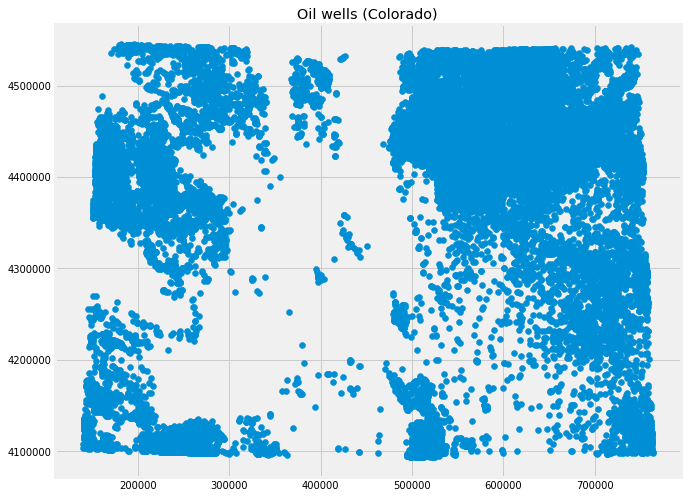

In [4]:
col_oil_gas.plot(figsize=(10, 20))
plt.title("Oil wells (Colorado)");

### Oil tank batteries data

In [5]:
# metadata: https://cogcc.state.co.us/documents/data/downloads/gis/metadata/Tank_Batteries_Metadata.html
# Tank Battery is a device used to store crude oil which is produced from a well.

col_tank_batteries = gpd.read_file("./TANK_BATTERIES_SHP")

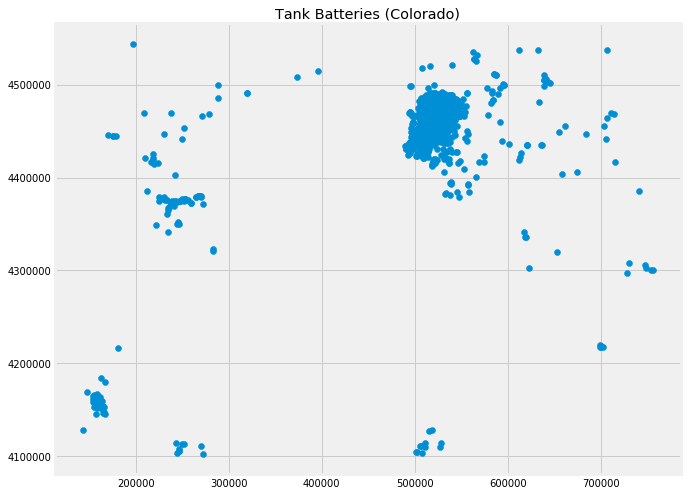

In [6]:
col_tank_batteries.plot(figsize=(10, 20))
plt.title("Tank Batteries (Colorado)");

### Oil pits data

In [7]:
# oil pits: https://cogcc.state.co.us/documents/data/downloads/gis/metadata/Pits_Metadata.html
col_pits = gpd.read_file("./PITS_SHP")

In [8]:
# col_pits.plot(figsize=(10, 20))

# plt.title("Pits (Colorado)");

#can see outliers outside of Colorado

### Colorado census blocks shape data

In [9]:
# Colorado census block shapes data: https://catalog.data.gov/dataset/tiger-line-shapefile-2019-2010-state-colorado-2010-census-block-state-based
col_blocks = gpd.read_file("./tl_2019_08_tabblock10/tl_2019_08_tabblock10.shp")

In [10]:
col_blocks.shape

(201062, 16)

In [11]:
col_blocks.head()[['geometry']].loc[0, :][0].bounds

(-104.92234, 39.689361, -104.91952, 39.692589)

In [12]:
# col_blocks.plot(figsize=(10, 20))
# plt.title("Colorado Block Level Borders");

### Plot all layers together

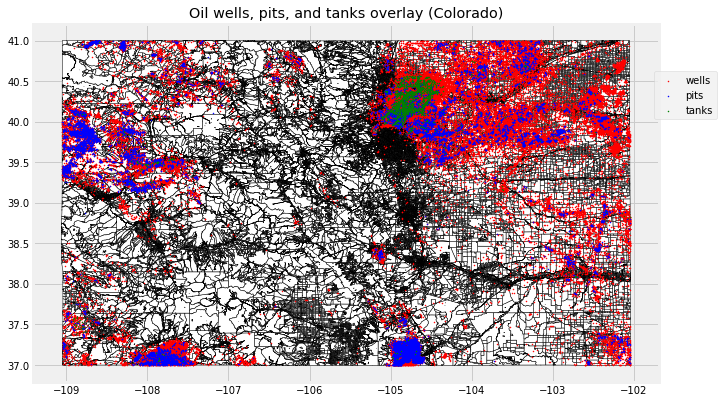

In [13]:
base = col_blocks.plot(color='white', edgecolor='black', figsize=(10, 20))

col_oil_gas = col_oil_gas.to_crs(col_blocks.crs)

#get rid of outlying points outside of Colorado
col_pits = col_pits[(col_pits['Latitude'] > 35) & (col_pits['Longitude'] < -100)] 

#need to make sure all are on the same crs (coordate reference system)
col_pits = col_pits.to_crs(col_blocks.crs)
col_tank_batteries = col_tank_batteries.to_crs(col_blocks.crs)

col_oil_gas.plot(ax=base, marker='o', color='red', markersize=1, label='wells')
col_pits.plot(ax=base, marker='o', color='blue', markersize=1, label='pits')
col_tank_batteries.plot(ax=base, marker='o', color='green', markersize=1, label='tanks')
plt.legend(loc="center right", bbox_to_anchor=(1.1, 0.8))
plt.title("Oil wells, pits, and tanks overlay (Colorado)")
plt.show();

## Filter out non-populated blocks <a id='filter_non_pop'></a>

In [14]:
#non populated block codes in Colorado BY GEOID to get unique codes!!

non_pop_blocks_geoid = []

In [15]:
#get all county codes in Colorado: https://simple.wikipedia.org/wiki/List_of_counties_in_Colorado
# 001 - 125 by odd nums

counties = list(map(str, np.arange(1, 127, 2)))
counties = list(map(lambda x: str.zfill(x, 3), counties))

In [16]:
#Get population data
#Using Decennial SF1 (Summary File 1) 2010 because it goes down to block level
# https://api.census.gov/data.html << find Decennial SF1 in 2010
#ACS5 has more recent population data until 2018, but only goes down to block group level
#Colorado is state code 08
#Have to use for loop over all counties because api doesn't let us iterate over all blocks at once 

for county_code in counties: 
    url = "https://api.census.gov/data/2010/dec/sf1?get=NAME,group(P1)&for=block:*&in=state:08%county:" + county_code
    r = requests.get(url)

    r.raise_for_status()
    
    data = r.json()

    block_df = pd.DataFrame(data)
    block_df.columns = block_df.iloc[0]
    block_df = block_df.iloc[1:]

    # P001001	Total	TOTAL POPULATION
    block_df['P001001'] = block_df['P001001'].apply(int)
    
    #what to do with margin of error in population counts? P001001ERR
    non_pop_blocks_geoid.extend(block_df[block_df['P001001'] == 0]['GEO_ID'].values.tolist())

In [17]:
#geoid's should all be unique
# 201,062 total census blocks in Colorado

pd.Series(non_pop_blocks_geoid).value_counts().sort_values()

1000000US080239726002630    1
1000000US080050067122010    1
1000000US081010032002336    1
1000000US081230010051029    1
1000000US080690017091196    1
                           ..
1000000US081230021034045    1
1000000US080690018082016    1
1000000US080759659001065    1
1000000US080130134013006    1
1000000US080319800001151    1
Length: 95332, dtype: int64

In [18]:
# should have 105730 populated blocks in Colorado 

201062 - 95332

105730

In [19]:
#Save file 

with open('path_to_file.json', 'w') as file:
    for item in non_pop_blocks_geoid: 
        line = json.dumps(item)
        file.write(line + '\n')

In [20]:
data_geoid_nonpop = []
with open('path_to_file.json', 'r') as file:
    for line in file: 
        data_item = json.loads(line)
        data_geoid_nonpop.append(data_item)

In [21]:
#get rid of first '1000000US' of strings 
data_geoid_nonpop = pd.Series(data_geoid_nonpop).apply(lambda x: x[9:])

In [22]:
col_blocks_copy = col_blocks.copy()

In [23]:
# Filter out blocks with no population
filter_col_blocks_pop = col_blocks_copy[~col_blocks_copy['GEOID10'].isin(data_geoid_nonpop)]

In [24]:
filter_col_blocks_pop.head()

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10,NAME10,MTFCC10,UR10,UACE10,UATYPE,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,08,031,005200,1010,080310052001010,Block 1010,G5040,U,23527,U,S,46625,0,+39.6907584,-104.9212054,"POLYGON ((-104.92234 39.68979, -104.92233 39.6..."
1,08,031,005200,3012,080310052003012,Block 3012,G5040,U,23527,U,S,17181,0,+39.6829812,-104.9217342,"POLYGON ((-104.92224 39.68374, -104.92224 39.6..."
2,08,031,005001,1009,080310050011009,Block 1009,G5040,U,23527,U,S,18812,0,+39.7020795,-104.9213633,"POLYGON ((-104.92164 39.70386, -104.92143 39.7..."
3,08,031,005001,1003,080310050011003,Block 1003,G5040,U,23527,U,S,20086,0,+39.7029551,-104.9158497,"POLYGON ((-104.91643 39.70241, -104.91643 39.7..."
4,08,031,001901,2017,080310019012017,Block 2017,G5040,U,23527,U,S,11437,0,+39.7329683,-105.0056579,"POLYGON ((-105.00615 39.73371, -105.00597 39.7..."


In [124]:
filter_col_blocks_pop.shape

(105730, 16)

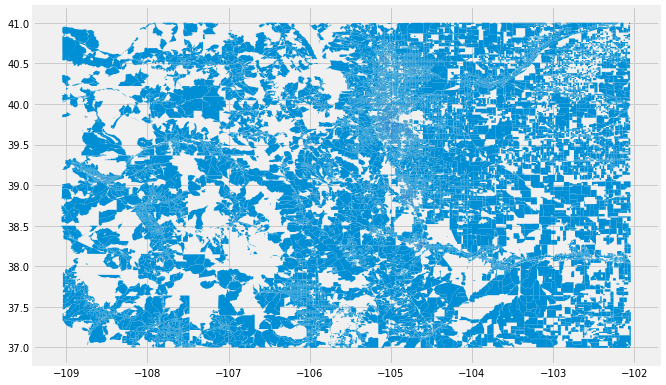

In [25]:
filter_col_blocks_pop.plot(figsize=(10, 20))

In [26]:
filter_col_blocks_pop_copy = filter_col_blocks_pop.copy()
col_blocks_buffered_df= filter_col_blocks_pop_copy.copy()

## Create buffers on populated census blocks <a id='buffer'></a>

According to fractracker.org at this [link](https://www.fractracker.org/2019/07/impact-of-a-2500-oil-and-gas-well-setback-in-california/), **2500 feet, or 0.762 km** seems to be the minimum buffer distance from oil fields to surrounding population in consideration of public health: 

"An established setback is therefore necessary to alleviate some of these health burdens carried by the most vulnerable Environmental Justice (EJ) communities. Health assessments by the Los Angeles County Department of Health and studies on ambient air quality near oil fields by Occidental College Researchers support the assumption that 2,500′ is the necessary distance to help alleviate the harsh conditions of degraded air quality. Living at a distance beyond 2,500′ from an oil and gas site does not mean you are not impacted by air and water contamination. Rather the concentrations of contaminants will be less harmful. In fact studies showed that health impacts increased with proximity to oil and gas, with associated impacts potentially experienced by communities living at distances up to 9.3 miles (Currie et al. 2017) and 10 miles (Whitworth et al. 2017)."

I'll then use 0.762km as the buffer distance around census blocks and then counting the number of oil facilities within the entire buffered block.

In [27]:
# calculating buffer distance 
# need buffer distance approximate number of degrees of longitude
# lat lon coords at Denver: 39.7392° N, 104.9903° W

# want to convert buffer distance of 0.762km to degrees longitude

# lat: 1 deg = 110.574km
# lon: 1 deg = 111.320*cos(latitude)km

#lat at Denver: 39.7392 deg >> 39.7392*pi/180 

#0.762km * (1 deg/ 111.320*cos(39.7392 converted into radians))
lat_radians = 39.7392 * np.pi/180
0.762/(111.32*np.cos(lat_radians))
#np.cos is in RADIANS

0.008901776731952719

In [28]:
#alt: convert 2000 feet >> 0.6096km

lat_radians = 39.7392 * np.pi/180
0.6096/(111.32*np.cos(lat_radians))

0.007121421385562175

In [29]:
# later will implement buffer considering lat/lon diff...
# buffer of 2000 ft for each block for now
col_blocks_buffered = filter_col_blocks_pop_copy.apply(lambda x: x.iloc[-1].buffer(0.007121421385562175), axis=1) #axis = 1 to apply to each row

In [30]:
#df with buffered blocks as geometry col
col_blocks_buffered_df['geometry'] = col_blocks_buffered 

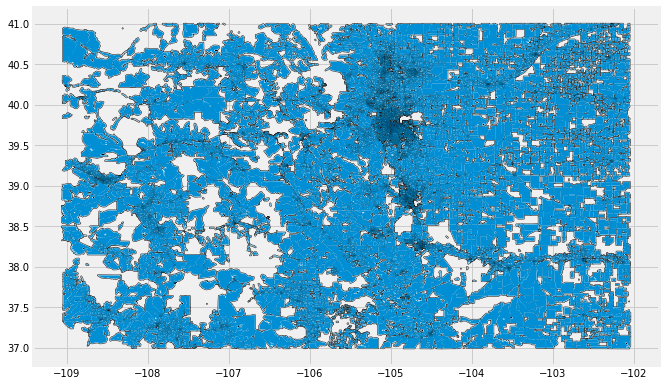

In [31]:
base = col_blocks_buffered_df.plot(color='white', edgecolor='black', figsize=(10, 20))

filter_col_blocks_pop_copy.plot(ax=base)

## Count the # of wells, pits, tanks within buffered blocks, partitioned by facility status <a id='count_totals'></a>

In [32]:
# counts oil facilities within buffered blocks

# fyi sjoin super slow (> 30 mins and lot of memory) when using > 0.01 
# Want multiple rows of the same block with different facility data, for a block with multiple wells in it
dfsjoin_oil = gpd.sjoin(col_blocks_buffered_df, col_oil_gas, op='intersects') #Spatial join Points to polygons
dfpivot_oil = pd.pivot_table(dfsjoin_oil,index='GEOID10',columns='fac_status',aggfunc={'fac_status':len}, fill_value=0)
dfpivot_oil.columns = dfpivot_oil.columns.droplevel()
dfpivot_oil['total'] = dfpivot_oil.sum(axis=1)
dfpivot_oil = dfpivot_oil.reset_index()
dfpivot_oil.head()

fac_status,GEOID10,AC,AL,CL,SU,total
0,080010083081000,0,0,1,0,1
1,080010083091019,0,0,1,0,1
2,080010083531002,1,2,2,0,5
3,080010083531004,11,4,7,0,22
4,080010083531006,2,0,1,0,3


In [125]:
dfpivot_oil.shape

(19843, 6)

In [33]:
# counts pits within buffered blocks

dfsjoin_pits = gpd.sjoin(col_blocks_buffered_df, col_pits, op='intersects') #Spatial join Points to polygons
dfpivot_pits = pd.pivot_table(dfsjoin_pits,index='GEOID10',columns='Facil_Stat',aggfunc={'Facil_Stat':len}, fill_value=0)
dfpivot_pits.columns = dfpivot_pits.columns.droplevel()
dfpivot_pits['total'] = dfpivot_pits.sum(axis=1)
dfpivot_pits = dfpivot_pits.reset_index()
dfpivot_pits.head()

Facil_Stat,GEOID10,AC,AL,CL,UN,total
0,080010083532027,0,0,2,0,2
1,080010084011003,0,0,2,0,2
2,080010084011007,0,0,6,0,6
3,080010084011008,0,0,5,0,5
4,080010084011009,0,0,15,0,15


In [34]:
# counts tanks within buffered blocks

dfsjoin_tanks = gpd.sjoin(col_blocks_buffered_df, col_tank_batteries, op='intersects') #Spatial join Points to polygons
dfpivot_tanks = pd.pivot_table(dfsjoin_tanks,index='GEOID10',columns='fac_status',aggfunc={'fac_status':len}, fill_value=0)
dfpivot_tanks.columns = dfpivot_tanks.columns.droplevel()
dfpivot_tanks['total'] = dfpivot_tanks.sum(axis=1)
dfpivot_tanks = dfpivot_tanks.reset_index()
dfpivot_tanks.head()

fac_status,GEOID10,AC,AL,CL,PR,SI,XX,total
0,080010084011003,1,0,1,0,0,0,2
1,080010084011007,1,0,0,0,0,0,1
2,080010084011008,1,0,0,0,0,0,1
3,080010084011009,1,0,0,0,0,0,1
4,080010084011010,3,0,0,0,0,0,3


## Create oil score per buffered block (equal weights for all tanks, pits, wells, status codes) <a id='block_oil_score'></a>

In [71]:
#sum total counts for all oil facilities, tanks, pits

merged_all = dfpivot_oil.merge(dfpivot_pits, on="GEOID10", how='outer').merge(dfpivot_tanks, on='GEOID10', how='outer')

merged_all_counts = merged_all.set_index("GEOID10")[['total_x', 'total_y', 'total']].sum(axis=1).reset_index()
merged_all_counts = merged_all_counts.rename(columns={0: 'oil_total'})

In [182]:
merged_all_counts.sort_values('oil_total', ascending=False).head()

,GEOID10,oil_total
19111,081230025022053,1325.0
18879,081230025011484,1307.0
19108,081230025022047,995.0
9860,080710003002238,889.0
9845,080710003002181,551.0


In [74]:
merged_all_counts.shape

(19953, 2)

In [132]:
# add geometry column (from non-buffered blocks), add FIPS_tract_id, turn into geodataframe

merged_all_counts_geo = merged_all_counts.merge(col_blocks, on="GEOID10", how="inner")
merged_all_counts_geo['FIPS_tract_id'] = merged_all_counts_geo['GEOID10'].str[:11]
merged_all_counts_geo = gpd.GeoDataFrame(merged_all_counts_geo, geometry='geometry')
merged_all_counts_geo.head()

,GEOID10,oil_total,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,NAME10,MTFCC10,UR10,UACE10,UATYPE,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry,FIPS_tract_id
0,080010083081000,1.0,08,001,008308,1000,Block 1000,G5040,U,23527,U,S,228843,0,+39.7724768,-104.8177083,"POLYGON ((-104.82823 39.77317, -104.82749 39.7...",08001008308
1,080010083091019,1.0,08,001,008309,1019,Block 1019,G5040,U,23527,U,S,952289,0,+39.7663113,-104.7827326,"POLYGON ((-104.79083 39.76899, -104.79080 39.7...",08001008309
2,080010083531002,5.0,08,001,008353,1002,Block 1002,G5040,R,None,None,S,1187260,1040,+39.7881957,-104.6281513,"POLYGON ((-104.63574 39.79075, -104.63566 39.7...",08001008353
3,080010083531004,22.0,08,001,008353,1004,Block 1004,G5040,R,None,None,S,21317699,33161,+39.7785643,-104.6847111,"POLYGON ((-104.71631 39.77767, -104.71628 39.7...",08001008353
4,080010083531006,3.0,08,001,008353,1006,Block 1006,G5040,R,None,None,S,1952672,0,+39.7601219,-104.7064338,"POLYGON ((-104.71588 39.75718, -104.71586 39.7...",08001008353


In [133]:
merged_all_counts_geo.shape

(19953, 18)

In [134]:
merged_all_counts_geo['Block_Area'] = merged_all_counts_geo.area

In [135]:
merged_all_counts_geo.head()

,GEOID10,oil_total,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,NAME10,MTFCC10,UR10,UACE10,UATYPE,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry,FIPS_tract_id,Block_Area
0,080010083081000,1.0,08,001,008308,1000,Block 1000,G5040,U,23527,U,S,228843,0,+39.7724768,-104.8177083,"POLYGON ((-104.82823 39.77317, -104.82749 39.7...",08001008308,0.000024
1,080010083091019,1.0,08,001,008309,1019,Block 1019,G5040,U,23527,U,S,952289,0,+39.7663113,-104.7827326,"POLYGON ((-104.79083 39.76899, -104.79080 39.7...",08001008309,0.000100
2,080010083531002,5.0,08,001,008353,1002,Block 1002,G5040,R,None,None,S,1187260,1040,+39.7881957,-104.6281513,"POLYGON ((-104.63574 39.79075, -104.63566 39.7...",08001008353,0.000125
3,080010083531004,22.0,08,001,008353,1004,Block 1004,G5040,R,None,None,S,21317699,33161,+39.7785643,-104.6847111,"POLYGON ((-104.71631 39.77767, -104.71628 39.7...",08001008353,0.002245
4,080010083531006,3.0,08,001,008353,1006,Block 1006,G5040,R,None,None,S,1952672,0,+39.7601219,-104.7064338,"POLYGON ((-104.71588 39.75718, -104.71586 39.7...",08001008353,0.000205


In [136]:
merged_all_counts_geo.columns

Index(['GEOID10', 'oil_total', 'STATEFP10', 'COUNTYFP10', 'TRACTCE10',
       'BLOCKCE10', 'NAME10', 'MTFCC10', 'UR10', 'UACE10', 'UATYPE',
       'FUNCSTAT10', 'ALAND10', 'AWATER10', 'INTPTLAT10', 'INTPTLON10',
       'geometry', 'FIPS_tract_id', 'Block_Area'],
      dtype='object')

## Aggregate scores from block level to tracts <a id='tract_oil_score'></a>

From Sid's work on blocks to tracts:

In [137]:
col_blocks_copy = col_blocks.copy()

In [146]:
# add shape area and FIPS_tract_id

col_blocks_copy['All_Blocks_Area'] = col_blocks_copy.area
col_blocks_copy['FIPS_tract_id'] = col_blocks_copy['GEOID10'].str[:11]

In [147]:
col_blocks.columns

Index(['STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'BLOCKCE10', 'GEOID10',
       'NAME10', 'MTFCC10', 'UR10', 'UACE10', 'UATYPE', 'FUNCSTAT10',
       'ALAND10', 'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'geometry'],
      dtype='object')

In [148]:
col_blocks.shape

(201062, 16)

In [155]:
# Find total area of each tract by summing corresponding blocks (which all have the same FIPS tract id)
# Using the non-buffered all blocks data
df_tracts = col_blocks_copy[['STATEFP10','FIPS_tract_id','All_Blocks_Area']].groupby('FIPS_tract_id',as_index=False).sum()
df_tracts = df_tracts.rename(columns={"All_Blocks_Area":"Tract_Area"})

In [159]:
df_tracts.head()

,FIPS_tract_id,Tract_Area
0,08001007801,0.000067
1,08001007802,0.000067
2,08001007900,0.000172
3,08001008000,0.000206
4,08001008100,0.000284


In [157]:
# 1249 census tracts in CO
df_tracts.shape

(1249, 2)

In [165]:
# Create new dataframe that for each block group row, specifies total tract area (for the tract in which the block group is located)
# We are only selecting the 5 indicators and shape information when merging.

df_with_areas = pd.merge(merged_all_counts_geo[['GEOID10','STATEFP10','FIPS_tract_id','oil_total','Block_Area','geometry']], df_tracts[['FIPS_tract_id','Tract_Area']], on='FIPS_tract_id')
df_with_areas.head()

,GEOID10,STATEFP10,FIPS_tract_id,oil_total,Block_Area,geometry,Tract_Area
0,080010083081000,08,08001008308,1.0,0.000024,"POLYGON ((-104.82823 39.77317, -104.82749 39.7...",0.000463
1,080010083091019,08,08001008309,1.0,0.000100,"POLYGON ((-104.79083 39.76899, -104.79080 39.7...",0.001278
2,080010083531002,08,08001008353,5.0,0.000125,"POLYGON ((-104.63574 39.79075, -104.63566 39.7...",0.011852
3,080010083531004,08,08001008353,22.0,0.002245,"POLYGON ((-104.71631 39.77767, -104.71628 39.7...",0.011852
4,080010083531006,08,08001008353,3.0,0.000205,"POLYGON ((-104.71588 39.75718, -104.71586 39.7...",0.011852


In [166]:
df_with_areas.shape

(19953, 7)

In [167]:
# Create a new column that gives proportion of tract that each block group contributes
df_with_areas['Tract_Proportion'] = df_with_areas['Block_Area'] / df_with_areas['Tract_Area']
df_with_areas.head()

,GEOID10,STATEFP10,FIPS_tract_id,oil_total,Block_Area,geometry,Tract_Area,Tract_Proportion
0,080010083081000,08,08001008308,1.0,0.000024,"POLYGON ((-104.82823 39.77317, -104.82749 39.7...",0.000463,0.052003
1,080010083091019,08,08001008309,1.0,0.000100,"POLYGON ((-104.79083 39.76899, -104.79080 39.7...",0.001278,0.078309
2,080010083531002,08,08001008353,5.0,0.000125,"POLYGON ((-104.63574 39.79075, -104.63566 39.7...",0.011852,0.010542
3,080010083531004,08,08001008353,22.0,0.002245,"POLYGON ((-104.71631 39.77767, -104.71628 39.7...",0.011852,0.189389
4,080010083531006,08,08001008353,3.0,0.000205,"POLYGON ((-104.71588 39.75718, -104.71586 39.7...",0.011852,0.017316


In [168]:
# Create new column with how much each block group contributes to the indicator
df_with_areas['oil_proportion'] = df_with_areas['oil_total'] * df_with_areas['Tract_Proportion']

df_with_areas.drop(columns={'oil_total'}, inplace=True)

df_with_areas.head()

,GEOID10,STATEFP10,FIPS_tract_id,Block_Area,geometry,Tract_Area,Tract_Proportion,oil_proportion
0,080010083081000,08,08001008308,0.000024,"POLYGON ((-104.82823 39.77317, -104.82749 39.7...",0.000463,0.052003,0.052003
1,080010083091019,08,08001008309,0.000100,"POLYGON ((-104.79083 39.76899, -104.79080 39.7...",0.001278,0.078309,0.078309
2,080010083531002,08,08001008353,0.000125,"POLYGON ((-104.63574 39.79075, -104.63566 39.7...",0.011852,0.010542,0.052711
3,080010083531004,08,08001008353,0.002245,"POLYGON ((-104.71631 39.77767, -104.71628 39.7...",0.011852,0.189389,4.166561
4,080010083531006,08,08001008353,0.000205,"POLYGON ((-104.71588 39.75718, -104.71586 39.7...",0.011852,0.017316,0.051949


In [185]:
df_with_areas.shape

(19953, 8)

In [237]:
# Create table with tract-average values for every tract
# Sums the proportions of all the block groups of a tract to create a total weighted average for each tract
tracts_w_oil = df_with_areas[['STATEFP10','FIPS_tract_id', 'oil_proportion']].groupby('FIPS_tract_id').sum()
tracts_w_oil = tracts_w_oil.rename(columns={'oil_proportion':'oil_score'})

In [238]:
tracts_w_oil.head()

,oil_score
FIPS_tract_id,
08001008308,0.052003
08001008309,0.078309
08001008353,4.793061
08001008401,27.517479
08001008402,51.397751


In [239]:
# 442/1249 >> around 0.35 of CO census tracts 
# btw census tracts are apparently:  
# "designed to be relatively homogeneous units with respect to population characteristics, economic status, and living conditions" and "average about 4,000 inhabitants"
tracts_w_oil.shape

(442, 1)

In [240]:
# Calculate percentiles
tracts_w_oil['oil_rank'] = tracts_w_oil.rank(method='average', na_option='keep', pct=True)*100

In [241]:
tracts_w_oil.head()

,oil_score,oil_rank
FIPS_tract_id,,
08001008308,0.052003,4.977376
08001008309,0.078309,8.597285
08001008353,4.793061,66.289593
08001008401,27.517479,87.556561
08001008402,51.397751,95.248869


In [242]:
tracts_w_oil.shape

(442, 2)

In [243]:
tracts_w_oil = tracts_w_oil.reset_index()

In [244]:
tracts_w_oil = tracts_w_oil.astype({'FIPS_tract_id': 'str'})
tracts_w_oil = tracts_w_oil.set_index("FIPS_tract_id")

In [245]:
tracts_w_oil.head()

,oil_score,oil_rank
FIPS_tract_id,,
08001008308,0.052003,4.977376
08001008309,0.078309,8.597285
08001008353,4.793061,66.289593
08001008401,27.517479,87.556561
08001008402,51.397751,95.248869


In [316]:
# fill in score and rank of 0 for tracts without any overlap with oil

oil_df_area = tracts_w_oil.merge(df_tracts, on='FIPS_tract_id', how='right').fillna(0)
oil_df = oil_df_area.drop(columns = 'Tract_Area')

In [317]:
oil_df.head()

,FIPS_tract_id,oil_score,oil_rank
0,08001008308,0.052003,4.977376
1,08001008309,0.078309,8.597285
2,08001008353,4.793061,66.289593
3,08001008401,27.517479,87.556561
4,08001008402,51.397751,95.248869


In [318]:
oil_df.shape

(1249, 3)

## Analysis <a id='analysis'></a>

### Merge final oil dataframe with combined indicators data

In [321]:
oil_df_area.head()

,FIPS_tract_id,oil_score,oil_rank,Tract_Area
0,08001008308,0.052003,4.977376,0.000463
1,08001008309,0.078309,8.597285,0.001278
2,08001008353,4.793061,66.289593,0.011852
3,08001008401,27.517479,87.556561,0.052883
4,08001008402,51.397751,95.248869,0.184549


In [322]:
oil_df_area.shape

(1249, 4)

In [351]:
# read combined indicators/scores data
# >> switch to using the db 

colorado_final = pd.read_csv("./Colorado_final.csv")

In [352]:
colorado_final.head()

,Unnamed: 0,NAME,state,FIPS_tract_id,lead_score,lead_rank,total_pop,poverty_score,poverty_rank,edu_score,...,HD_rank,demographic_score,exposure_score,effects_score,sensitive_score,Pollution_Burden,Pop_Char,FinalScore,missing_values,Final_Rank
0,0,"Census Tract 9646, Delta County, Colorado",8,8029964600,0.234207,78.866397,3527.0,34.902183,72.639225,4.4,...,92.298387,46.323682,7.289137,27.526682,63.625107,16.464698,54.974395,8.086725,0,6.416667
1,1,"Census Tract 9647, Delta County, Colorado",8,8029964700,0.119621,61.700405,3815.0,35.989515,73.688458,10.2,...,91.411290,52.075859,9.818064,22.780433,58.973025,17.411542,55.524442,8.637337,0,7.416667
2,2,"Census Tract 9649, Delta County, Colorado",8,8029964900,0.080954,52.388664,5683.0,48.161182,88.539144,6.9,...,93.508065,66.229316,15.850643,26.138261,55.463863,24.563397,60.846590,13.353131,0,17.250000
3,3,"Census Tract 9648, Delta County, Colorado",8,8029964800,0.147783,66.720648,4000.0,35.550000,73.284907,17.9,...,88.991935,69.436468,16.695108,42.247252,53.042387,30.777525,61.239427,16.839271,0,25.166667
4,4,"Census Tract 9650, Delta County, Colorado",8,8029965000,0.163839,68.744939,4707.0,27.979605,58.111380,5.3,...,76.048387,41.414737,6.997643,25.358275,38.656541,15.450402,40.035639,5.526434,0,1.916667


In [353]:
colorado_final['FIPS_tract_id'] =  '0' + colorado_final['FIPS_tract_id'].astype(str)

In [356]:
# merge with combined indicators notebook

co_final_oil = oil_df_area.merge(colorado_final, on='FIPS_tract_id', how='inner')

In [357]:
co_final_oil.head()

,FIPS_tract_id,oil_score,oil_rank,Tract_Area,Unnamed: 0,NAME,state,lead_score,lead_rank,total_pop,...,HD_rank,demographic_score,exposure_score,effects_score,sensitive_score,Pollution_Burden,Pop_Char,FinalScore,missing_values,Final_Rank
0,08001008308,0.052003,4.977376,0.000463,1171,"Census Tract 83.08, Adams County, Colorado",8,0.062083,43.562753,5545.0,...,54.354839,91.144876,77.210568,63.748579,71.499338,98.460095,81.322107,71.536441,0,98.416667
1,08001008309,0.078309,8.597285,0.001278,1195,"Census Tract 83.09, Adams County, Colorado",8,0.048730,35.546559,4098.0,...,44.072581,91.333349,65.337627,63.922763,71.142752,86.645214,81.238050,62.887239,2,94.250000
2,08001008353,4.793061,66.289593,0.011852,1196,"Census Tract 83.53, Adams County, Colorado",8,0.033126,26.072874,7907.0,...,29.677419,68.940312,54.133729,58.377105,68.115118,73.592764,68.527715,45.056745,0,76.583333
3,08001008401,27.517479,87.556561,0.052883,780,"Census Tract 84.01, Adams County, Colorado",8,0.089650,55.303644,4710.0,...,73.185484,50.793612,29.950249,35.544316,56.432838,41.798354,53.613225,20.021175,0,32.750000
4,08001008402,51.397751,95.248869,0.184549,1187,"Census Tract 84.02, Adams County, Colorado",8,0.079539,51.578947,4894.0,...,81.330645,30.949075,19.343661,34.431082,73.056871,30.820688,52.002973,14.319537,0,19.500000


In [358]:
co_final_oil.shape

(1249, 55)

### Exploratory data analysis btw oil and other indicators/final scores

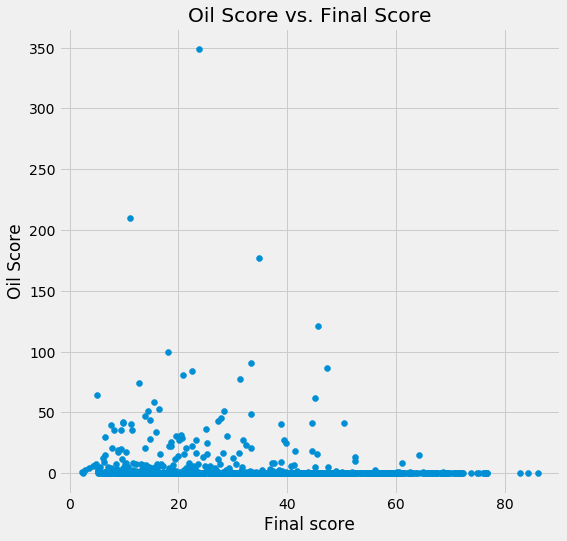

In [385]:
plt.figure(figsize=(8, 8))
plt.xlabel("Final score")
plt.ylabel("Oil Score")
plt.scatter(co_final_oil['FinalScore'], co_final_oil['oil_score'])
plt.title("Oil Score vs. Final Score");

In [375]:
co_final_oil = co_final_oil.dropna()

In [386]:
# R^2 (coefficient of determination) regression score
regr = linear_model.LinearRegression()
regr.fit(co_final_oil[['FinalScore']], co_final_oil[['oil_score']])
regr.score(co_final_oil[['FinalScore']], co_final_oil[['oil_score']])

0.00982667412738858

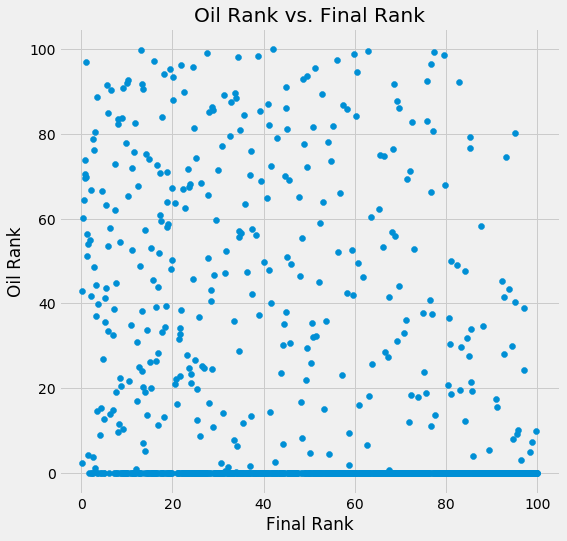

In [390]:
plt.figure(figsize=(8, 8))
# plt.ylim(0, 250)
plt.xlabel("Final Rank")
plt.ylabel("Oil Rank")
plt.scatter(co_final_oil['Final_Rank'], co_final_oil['oil_rank'])
plt.title("Oil Rank vs. Final Rank");

In [397]:
regr = linear_model.LinearRegression()
regr.fit(co_final_oil[['Final_Rank']], co_final_oil[['oil_rank']])
regr.score(co_final_oil[['Final_Rank']], co_final_oil[['oil_rank']])

0.08614518486772493

# a mess >>

In [11]:
col_wells = gpd.read_file("./WELLS_SHP")

In [12]:
col_wells

,API,API_County,API_Seq,API_Label,Operat_Num,Operator,Well_Num,Well_Name,Well_Title,Citing_Typ,...,Qtr_Qtr,Section,Township,Range,Meridian,Latitude,Longitude,Utm_X,Utm_Y,geometry
0,00105000,001,05000,05-001-05000,88925,TOMBERLIN* BILL,1,UPRR-JOLLY,1 UPRR-JOLLY,ACTUAL,...,SESE,35,3S,57W,6,39.741587,-103.727484,609032,4399851,POINT (609032.000 4399851.000)
1,00105001,001,05001,05-001-05001,70500,PLAINS EX,1-V,STATE,1-V STATE,ACTUAL,...,NWSE,36,3S,57W,6,39.745257,-103.713113,610257,4400276,POINT (610257.000 4400276.000)
2,00105002,001,05002,05-001-05002,100630,JAMESON COMPANY* W L,1,JAMESON,1 JAMESON,HISTORICAL,...,C,35,3S,66W,6,39.747303,-104.744385,521899,4399742,POINT (521899.000 4399742.000)
3,00105003,001,05003,05-001-05003,85100,SUPERIOR OIL COMPANY,1-31,UPRR-NOONAN,1-31 UPRR-NOONAN,ACTUAL,...,SENE,31,3S,58W,6,39.748516,-103.910839,593312,4400413,POINT (593312.000 4400413.000)
4,00105004,001,05004,05-001-05004,15550,CHAMPLIN PETROLEUM COMPANY,1,PLACIDO RICO,1 PLACIDO RICO,ACTUAL,...,NWNE,32,3S,59W,6,39.752736,-104.008242,584962,4400784,POINT (584962.000 4400784.000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120646,12560006,125,60006,05-125-60006,22900,DAVIS OIL COMPANY,1,ANDERSON,1 ANDERSON,ACTUAL,...,SWSE,29,1S,47W,6,39.933970,-102.658832,700044,4423053,POINT (700044.000 4423053.000)
120647,12560007,125,60007,05-125-60007,69450,PETROLEUM INC,1,CHANDLER,1 CHANDLER,ACTUAL,...,NESE,11,1S,48W,6,39.979959,-102.712034,695366,4428040,POINT (695366.000 4428040.000)
120648,12560008,125,60008,05-125-60008,97976,WYTEX SERVICE CORP,1,PARTCH,1 PARTCH,ACTUAL,...,SESE,17,1S,48W,6,39.961929,-102.767625,690669,4425918,POINT (690669.000 4425918.000)
120649,12560009,125,60009,05-125-60009,72555,PUCKETT-WARREN OIL CO,1-32,SEEDORF,1-32 SEEDORF,ACTUAL,...,NENE,32,1S,48W,6,39.928609,-102.765785,690919,4422223,POINT (690919.000 4422223.000)


In [15]:
col_oil_gas.columns

Index(['loc_id', 'fac_status', 'fac_name', 'fac_num', 'oper_name', 'oper_num',
       'lat', 'long', 'utm_x', 'utm_y', 'qtrqtr', 'sec', 'twp', 'range',
       'meridian', 'county', 'county_API', 'municipal', 'geometry'],
      dtype='object')

In [13]:
col_wells.columns

Index(['API', 'API_County', 'API_Seq', 'API_Label', 'Operat_Num', 'Operator',
       'Well_Num', 'Well_Name', 'Well_Title', 'Citing_Typ', 'Spud_Date',
       'Ground_Ele', 'Max_MD', 'Max_TVD', 'Field_Code', 'Field_Name',
       'Facil_Id', 'Facil_Type', 'Facil_Stat', 'Stat_Date', 'Loc_Qual',
       'Loc_ID', 'Loc_Name', 'Dist_N_S', 'Dir_N_S', 'Dist_E_W', 'Dir_E_W',
       'Qtr_Qtr', 'Section', 'Township', 'Range', 'Meridian', 'Latitude',
       'Longitude', 'Utm_X', 'Utm_Y', 'geometry'],
      dtype='object')

In [226]:
col_wells[['Spud_Date', 'Facil_Stat', 'Stat_Date']]['Facil_Stat'].value_counts()

PR    38082
PA    23564
DA    20809
AL    19396
SI     8268
XX     5292
TA     2630
DG     1329
IJ      734
AC      324
WO      108
SU       56
DM       44
AB       14
pa        1
Name: Facil_Stat, dtype: int64

In [37]:
col_wells['Spud_Date'] = col_wells['Spud_Date'].astype('datetime64[ns]')

In [84]:
wells_newer = col_wells[col_wells["Spud_Date"] > datetime.date(2000,1,1)][["Spud_Date", "Facil_Stat", "Stat_Date", "geometry"]]
wells_newer = wells_newer.to_crs(col_blocks_buffered_df.crs)
wells_join_oil = gpd.sjoin(col_blocks_buffered_df, wells_newer, op='intersects')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.


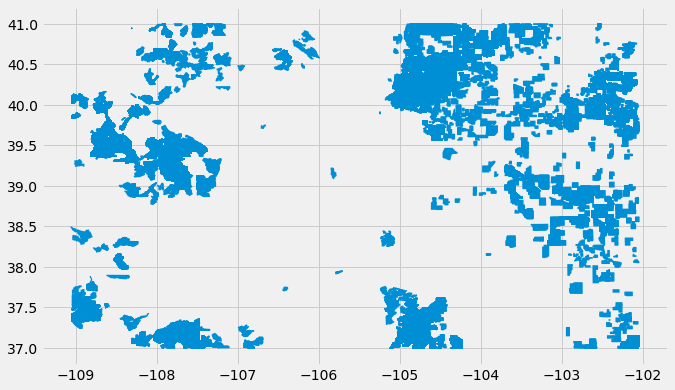

In [86]:
wells_join_oil.plot(figsize=(10, 20))

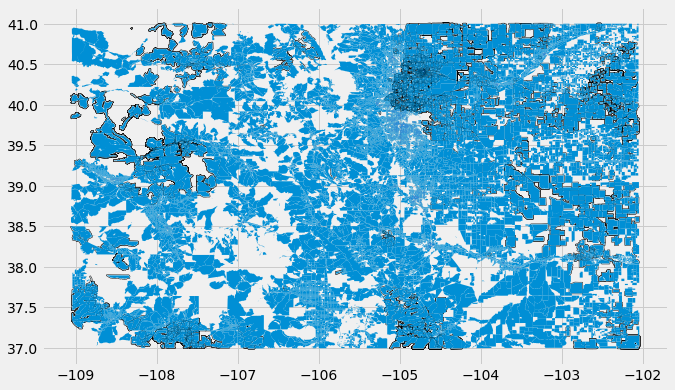

In [176]:
base = wells_join_oil.plot(color='white', edgecolor='black', figsize=(10, 20))

filter_col_blocks_pop_copy.plot(ax=base)

In [87]:
wells_join_oil

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10,NAME10,MTFCC10,UR10,UACE10,UATYPE,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry,index_right,Spud_Date,Facil_Stat,Stat_Date
89,08,007,940400,1106,080079404001106,Block 1106,G5040,R,None,None,S,32371989,0,+37.0372906,-107.2851940,"POLYGON ((-107.34107 37.03423, -107.34107 37.0...",6764,2009-08-25,XX,2009-07-13
7970,08,007,940400,1078,080079404001078,Block 1078,G5040,R,None,None,S,36523111,0,+37.0551624,-107.3663675,"POLYGON ((-107.41494 37.06454, -107.41497 37.0...",6764,2009-08-25,XX,2009-07-13
20903,08,007,940400,1115,080079404001115,Block 1115,G5040,R,None,None,S,2084942,0,+37.0586300,-107.4134250,"POLYGON ((-107.42003 37.06130, -107.41999 37.0...",6764,2009-08-25,XX,2009-07-13
89,08,007,940400,1106,080079404001106,Block 1106,G5040,R,None,None,S,32371989,0,+37.0372906,-107.2851940,"POLYGON ((-107.34107 37.03423, -107.34107 37.0...",6766,2009-07-29,XX,2009-07-13
89,08,007,940400,1106,080079404001106,Block 1106,G5040,R,None,None,S,32371989,0,+37.0372906,-107.2851940,"POLYGON ((-107.34107 37.03423, -107.34107 37.0...",6768,2010-07-30,PR,2017-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200521,08,045,951901,1047,080459519011047,Block 1047,G5040,R,None,None,S,4601991,0,+39.5147821,-107.6425579,"POLYGON ((-107.66809 39.52018, -107.66800 39.5...",26659,2012-04-02,PA,2016-08-23
200521,08,045,951901,1047,080459519011047,Block 1047,G5040,R,None,None,S,4601991,0,+39.5147821,-107.6425579,"POLYGON ((-107.66809 39.52018, -107.66800 39.5...",26661,2012-04-01,PA,2016-08-23
200521,08,045,951901,1047,080459519011047,Block 1047,G5040,R,None,None,S,4601991,0,+39.5147821,-107.6425579,"POLYGON ((-107.66809 39.52018, -107.66800 39.5...",26662,2012-04-01,PA,2016-08-23
200521,08,045,951901,1047,080459519011047,Block 1047,G5040,R,None,None,S,4601991,0,+39.5147821,-107.6425579,"POLYGON ((-107.66809 39.52018, -107.66800 39.5...",26663,2012-04-04,PA,2016-08-23


In [94]:
wells_join_oil['FIPS_tract_id'] = wells_join_oil['GEOID10'].str[:11]

In [215]:
wells_grouped = wells_join_oil.groupby('FIPS_tract_id').first().reset_index()

In [218]:
GeoDataFrame(wells_grouped, geometry=geometry)

NameError: name 'GeoDataFrame' is not defined

In [217]:
type(wells_grouped)

pandas.core.frame.DataFrame

In [188]:
wells_grouped.shape

(196, 20)

In [181]:
testinggg1 = wells_grouped.merge(colorado_final, on='FIPS_tract_id', how='inner')

In [222]:
colorado_final.columns

Index(['Unnamed: 0', 'NAME', 'state', 'FIPS_tract_id', 'lead_score',
       'lead_rank', 'total_pop', 'poverty_score', 'poverty_rank', 'edu_score',
       'edu_rank', 'lin_score', 'lin_rank', 'unemploy_score', 'unemploy_rank',
       'nonwhitePerc', 'nonwhite_rank', 'HouseBurden_score',
       'HouseBurden_rank', 'ozone_score', 'ozone_rank', 'diesel_score',
       'diesel_rank', 'toxics_score', 'toxics_rank', 'PM25_score', 'PM25_rank',
       'Avg_PTRAF', 'Avg_PTSDF', 'Avg_PRMP', 'Avg_PWDIS', 'Avg_PNPL',
       'PTRAF_rank', 'PTSDF_rank', 'PRMP_rank', 'PWDIS_rank', 'PNPL_rank',
       'asthma_score', 'asthma_rank', 'LB_score', 'LB_rank', 'HD_score',
       'HD_rank', 'demographic_score', 'exposure_score', 'effects_score',
       'sensitive_score', 'Pollution_Burden', 'Pop_Char', 'FinalScore',
       'missing_values', 'Final_Rank'],
      dtype='object')

In [182]:
testinggg1

,FIPS_tract_id,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10,NAME10,MTFCC10,UR10,UACE10,...,HD_rank,demographic_score,exposure_score,effects_score,sensitive_score,Pollution_Burden,Pop_Char,FinalScore,missing_values,Final_Rank
0,08001008353,08,001,008353,1087,080010083531087,Block 1087,G5040,R,NaN,...,29.677419,68.940312,54.133729,58.377105,68.115118,73.592764,68.527715,45.056745,0,76.583333
1,08001008401,08,001,008401,1236,080010084011236,Block 1236,G5040,R,NaN,...,73.185484,50.793612,29.950249,35.544316,56.432838,41.798354,53.613225,20.021175,0,32.750000
2,08001008402,08,001,008402,1141,080010084021141,Block 1141,G5040,R,NaN,...,81.330645,30.949075,19.343661,34.431082,73.056871,30.820688,52.002973,14.319537,0,19.500000
3,08001008523,08,001,008523,2012,080010085232012,Block 2012,G5040,R,23527,...,73.185484,53.133154,53.613238,43.535045,53.577341,68.124920,53.355248,32.474434,0,58.250000
4,08001008526,08,001,008526,1009,080010085261009,Block 1009,G5040,U,23527,...,70.564516,49.915776,77.998072,54.958104,44.723777,96.317440,47.319777,40.719841,0,71.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,08123002300,08,123,002300,5005,081230023005005,Block 5005,G5040,R,NaN,...,81.330645,56.093830,27.900683,34.332489,63.824158,39.344846,59.958994,21.076604,0,34.916667
192,08123002501,08,123,002501,1307,081230025011307,Block 1307,G5040,R,NaN,...,81.330645,45.065224,14.926804,36.242552,53.863079,27.007655,49.464152,11.935370,2,14.666667
193,08123002502,08,123,002502,2108,081230025022108,Block 2108,G5040,R,NaN,...,92.298387,56.116458,40.907915,48.734035,37.279581,57.152593,46.698020,23.844755,0,42.000000
194,08125963100,08,125,963100,2019,081259631002019,Block 2019,G5040,R,NaN,...,97.177419,53.454684,10.768668,35.424044,59.625667,22.576682,56.540175,11.404486,0,13.666667


In [195]:
colorado_final.shape

(1249, 52)

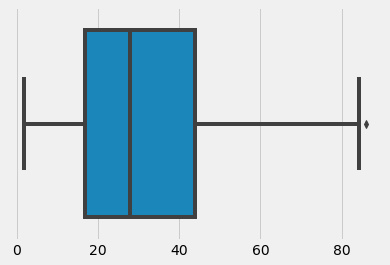

In [227]:
sns.boxplot(list(colorado_final['FinalScore'].values));
#17-45

In [230]:
mid_col_final = colorado_final[(colorado_final['FinalScore'] >= 20) & (colorado_final['FinalScore'] <= 45)]

In [231]:
mid_col_final

,Unnamed: 0,NAME,state,FIPS_tract_id,lead_score,lead_rank,total_pop,poverty_score,poverty_rank,edu_score,...,HD_rank,demographic_score,exposure_score,effects_score,sensitive_score,Pollution_Burden,Pop_Char,FinalScore,missing_values,Final_Rank
18,18,"Census Tract 28.01, Denver County, Colorado",8,08031002801,0.370286,91.821862,2733.0,17.526528,33.171913,3.7,...,13.508065,27.039661,84.299358,94.104965,17.135707,115.667680,22.087684,22.825519,0,39.750000
21,21,"Census Tract 28.03, Denver County, Colorado",8,08031002803,0.233895,78.704453,4721.0,19.572125,38.418079,0.9,...,25.766129,43.057802,83.381891,92.330162,27.476004,114.158612,35.266903,35.969505,0,64.333333
27,27,"Census Tract 40.02, Denver County, Colorado",8,08031004002,0.318739,88.016194,3453.0,11.497249,16.707022,2.5,...,81.330645,20.817116,77.143991,78.179700,35.072336,103.203891,27.944726,25.766437,0,45.583333
28,28,"Census Tract 40.04, Denver County, Colorado",8,08031004004,0.186792,72.550607,1967.0,15.404169,28.248588,5.7,...,70.564516,31.145620,82.745845,56.767928,40.821986,101.668488,35.983803,32.685255,0,58.583333
29,29,"Census Tract 42.01, Denver County, Colorado",8,08031004201,0.598166,99.838057,4809.0,11.977542,18.079096,4.1,...,57.943548,35.987733,78.225258,75.612127,41.794971,103.429300,38.891352,35.938097,0,64.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1223,1223,"Census Tract 127.08, Boulder County, Colorado",8,08013012708,0.036548,28.016194,5040.0,14.047619,23.567393,0.8,...,54.354839,24.706115,52.125609,65.331021,38.498442,73.902616,31.602279,20.865878,0,34.583333
1225,1225,"Census Tract 132.07, Boulder County, Colorado",8,08013013207,0.048678,35.465587,4532.0,21.557811,43.825666,2.0,...,41.290323,36.112893,58.786908,43.169979,59.998424,73.176901,48.055658,31.417889,0,56.250000
1227,1227,"Census Tract 125.08, Boulder County, Colorado",8,08013012508,0.112469,60.080972,3225.0,28.124031,58.514931,3.4,...,5.201613,43.970204,59.181912,68.989773,38.298933,82.178503,41.134569,30.201160,0,54.333333
1228,1228,"Census Tract 129.03, Boulder County, Colorado",8,08013012903,0.008064,9.068826,2425.0,13.237113,21.226796,2.8,...,54.354839,28.769939,60.601233,53.326976,44.733583,78.376892,36.751761,25.735028,0,45.500000


In [232]:
mid_oil = wells_join_oil.merge(mid_col_final, on='FIPS_tract_id', how='inner')

In [243]:
mid_oil = mid_oil.groupby('FIPS_tract_id').first().reset_index()

In [256]:
mid_oil.columns

Index(['FIPS_tract_id', 'STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'BLOCKCE10',
       'GEOID10', 'NAME10', 'MTFCC10', 'UR10', 'UACE10', 'UATYPE',
       'FUNCSTAT10', 'ALAND10', 'AWATER10', 'INTPTLAT10', 'INTPTLON10',
       'geometry', 'index_right', 'Spud_Date', 'Facil_Stat', 'Stat_Date',
       'Unnamed: 0', 'NAME', 'state', 'lead_score', 'lead_rank', 'total_pop',
       'poverty_score', 'poverty_rank', 'edu_score', 'edu_rank', 'lin_score',
       'lin_rank', 'unemploy_score', 'unemploy_rank', 'nonwhitePerc',
       'nonwhite_rank', 'HouseBurden_score', 'HouseBurden_rank', 'ozone_score',
       'ozone_rank', 'diesel_score', 'diesel_rank', 'toxics_score',
       'toxics_rank', 'PM25_score', 'PM25_rank', 'Avg_PTRAF', 'Avg_PTSDF',
       'Avg_PRMP', 'Avg_PWDIS', 'Avg_PNPL', 'PTRAF_rank', 'PTSDF_rank',
       'PRMP_rank', 'PWDIS_rank', 'PNPL_rank', 'asthma_score', 'asthma_rank',
       'LB_score', 'LB_rank', 'HD_score', 'HD_rank', 'demographic_score',
       'exposure_score', 'effects_sco

In [261]:
# mid_oil.plot()

In [244]:
mid_oil.shape

(64, 72)

In [245]:
mid_non_near_wells = mid_col_final[~mid_col_final['FIPS_tract_id'].isin(mid_oil['FIPS_tract_id'])]

In [246]:
mid_non_near_wells.shape

(462, 52)

In [247]:
# mid_oil_2 = wells_join_oil.merge(mid_col_final, on='FIPS_tract_id', how='right')

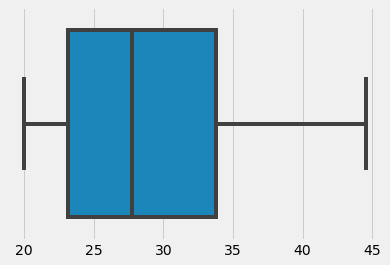

In [248]:
sns.boxplot(list(mid_oil['FinalScore'].values));

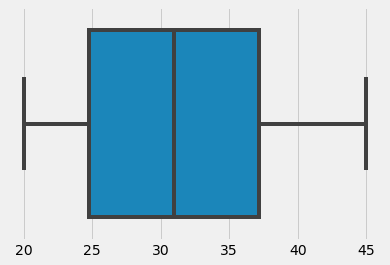

In [249]:
sns.boxplot(list(mid_non_near_wells['FinalScore'].values));

In [196]:
non_near_wells = colorado_final[~colorado_final['FIPS_tract_id'].isin(testinggg1['FIPS_tract_id'])]

In [198]:
non_near_wells.shape

(1053, 52)

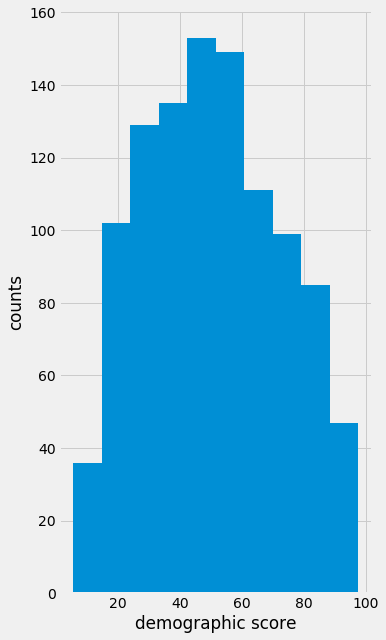

In [199]:
plt.figure(figsize=(5, 10))
# plt.ylim(0, 250)
plt.xlabel("demographic score")
plt.ylabel("counts")
plt.hist(non_near_wells['demographic_score']);

In [183]:
testinggg1.columns

Index(['FIPS_tract_id', 'STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'BLOCKCE10',
       'GEOID10', 'NAME10', 'MTFCC10', 'UR10', 'UACE10', 'UATYPE',
       'FUNCSTAT10', 'ALAND10', 'AWATER10', 'INTPTLAT10', 'INTPTLON10',
       'geometry', 'index_right', 'Spud_Date', 'Facil_Stat', 'Stat_Date',
       'Unnamed: 0', 'NAME', 'state', 'lead_score', 'lead_rank', 'total_pop',
       'poverty_score', 'poverty_rank', 'edu_score', 'edu_rank', 'lin_score',
       'lin_rank', 'unemploy_score', 'unemploy_rank', 'nonwhitePerc',
       'nonwhite_rank', 'HouseBurden_score', 'HouseBurden_rank', 'ozone_score',
       'ozone_rank', 'diesel_score', 'diesel_rank', 'toxics_score',
       'toxics_rank', 'PM25_score', 'PM25_rank', 'Avg_PTRAF', 'Avg_PTSDF',
       'Avg_PRMP', 'Avg_PWDIS', 'Avg_PNPL', 'PTRAF_rank', 'PTSDF_rank',
       'PRMP_rank', 'PWDIS_rank', 'PNPL_rank', 'asthma_score', 'asthma_rank',
       'LB_score', 'LB_rank', 'HD_score', 'HD_rank', 'demographic_score',
       'exposure_score', 'effects_sco

In [184]:
testinggg2

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10,NAME10,MTFCC10,UR10,UACE10,UATYPE,...,HD_rank,demographic_score,exposure_score,effects_score,sensitive_score,Pollution_Burden,Pop_Char,FinalScore,missing_values,Final_Rank
0,08,007,940400,1106,080079404001106,Block 1106,G5040,R,None,None,...,83.185484,46.073576,18.544347,22.063422,42.518668,25.898821,44.296122,10.249535,0,11.166667
1,08,007,940400,1078,080079404001078,Block 1078,G5040,R,None,None,...,83.185484,46.073576,18.544347,22.063422,42.518668,25.898821,44.296122,10.249535,0,11.166667
2,08,007,940400,1115,080079404001115,Block 1115,G5040,R,None,None,...,83.185484,46.073576,18.544347,22.063422,42.518668,25.898821,44.296122,10.249535,0,11.166667
3,08,007,940400,1106,080079404001106,Block 1106,G5040,R,None,None,...,83.185484,46.073576,18.544347,22.063422,42.518668,25.898821,44.296122,10.249535,0,11.166667
4,08,007,940400,1106,080079404001106,Block 1106,G5040,R,None,None,...,83.185484,46.073576,18.544347,22.063422,42.518668,25.898821,44.296122,10.249535,0,11.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.201613,64.121204,15.648654,19.850465,32.997231,22.265475,48.559218,9.659666,0,9.916667
134366,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,94.153226,60.283512,10.330090,25.883444,63.888760,18.957905,62.086136,10.515827,0,12.083333
134367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,99.435484,13.341387,27.114740,34.238422,55.796619,38.527548,34.569003,11.899170,0,14.583333
134368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98.750000,27.378009,44.055194,57.638311,61.003659,63.267965,44.190834,24.978969,0,44.666667


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


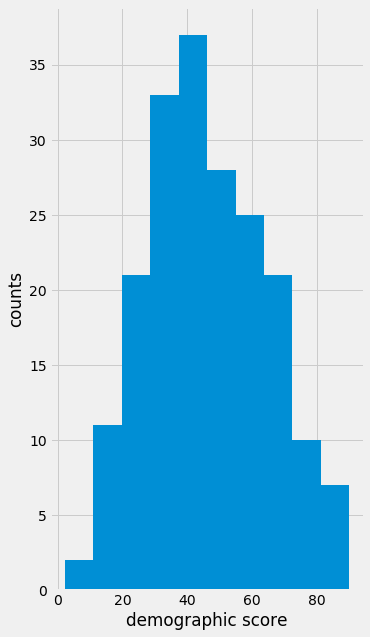

In [208]:
plt.figure(figsize=(5, 10))
# plt.ylim(0, 250)
plt.xlabel("demographic score")
plt.ylabel("counts")
plt.hist(testinggg1['demographic_score']);

#OOH COMPARE THISSS WITH THE GENERAL HISTOGRAM OF DISTRIBUTIONS OF JUST THE POPULATED TRACTS >> SEE HERE THERE IS A SPIKE 
#AT 60 but when i do right join, where I include alll the populated tracks, much more medium? 
    # make comparisons on the distributions for just the tracts that are near the recently fracked 


In [167]:
testinggg2 = wells_join_oil.merge(colorado_final, on='FIPS_tract_id', how='right')

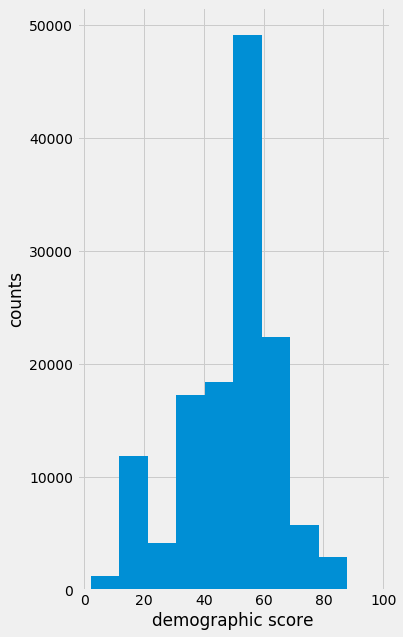

In [168]:
plt.figure(figsize=(5, 10))
# plt.ylim(0, 250)
plt.xlabel("demographic score")
plt.ylabel("counts")
plt.hist(testinggg2['demographic_score']);

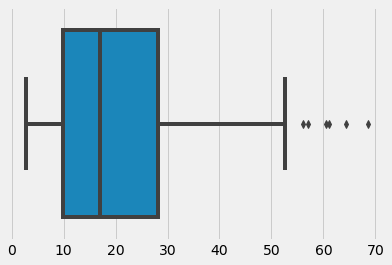

In [223]:
sns.boxplot(list(testinggg1['FinalScore'].values));
#just the ones near recently spudded

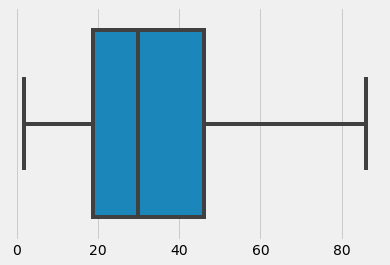

In [224]:
sns.boxplot(list(non_near_wells['FinalScore'].values));

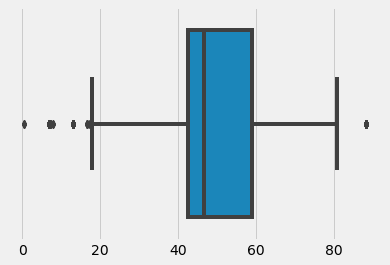

In [171]:
sns.boxplot(list(testinggg1['sensitive_score'].values));
#just the ones near recently spudded

#make sure to line up the axis

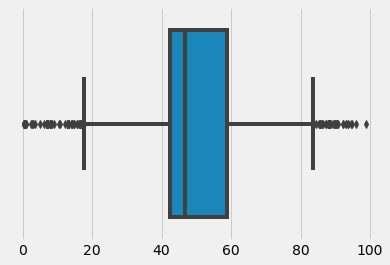

In [172]:
sns.boxplot(list(testinggg2['sensitive_score'].values));

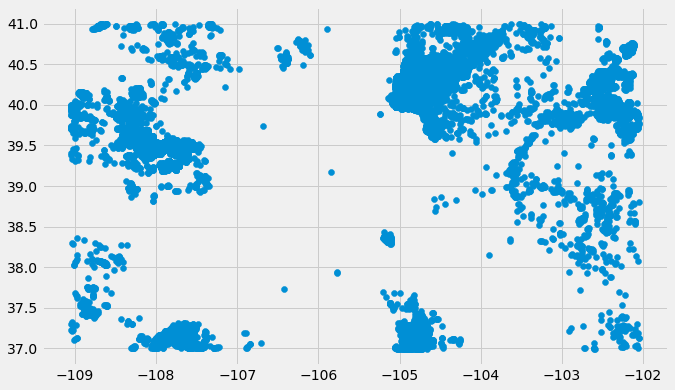

In [81]:
wells_newer.plot(figsize=(10, 20))

## Research on weights <a id='weights_research'></a>

### Weights for wells vs. tanks vs. pits

__Pits seem to be worse environmentally than tanks__

This 2015 paper from Research the Future (https://pdfs.semanticscholar.org/6d06/8a9ff17cbd092710d2e8cdc789d0b0615b85.pdf) describes the United States Department of the Interior Bureau of Land Management (BLM) having the most stringent regulations on pits compared to tanks on page 29: 

"BLM is perhaps the most stringent regulator of pits, basically not allowing their use. In
2015, BLM released final standards for hydraulic fracturing on public and tribal lands, which
include a new requirement that all produced water be stored in “rigid, enclosed, covered, or
netted and screened above-ground tanks, subject to very limited exceptions in which lined pits
could be used” that may not exceed a 500-barrel capacity (BLM 2015). BLM’s justification for
this new requirement is based on the argument that tanks are less prone to leaking than pits, are
safer for wildlife, and will have fewer air emissions. In addition, BLM cited several benefits that
tanks afford to oil and gas operators, including quicker site preparation, increases in safety, and
fewer monitoring and mitigation requirements."

Also, in this Instruction Memorandum No. WY-2012-007 by the BLM from 2012 (need to find more recent policy...) on the "Management of Oil and Gas Exploration and Production Pits," (https://www.blm.gov/policy/im-wy-2012-007) closed tanks are preferred over open pits: 

"Use of enclosed tanks and closed loop or semi-closed loop systems is environmentally preferable to the use of open pits and is to be encouraged by the BLM. Open production pits are to be strongly discouraged. Closed tanks and systems minimize waste, entry by wildlife, fugitive emissions that affect air quality, and reduce the risk of soil and groundwater contamination. In addition, the use of tanks instead of pits expedites the ability to complete interim reclamation. Costs may be reduced with the use of tanks, particularly when the pit requires solidification or netting."

I'm assuming oil wells are the most environmentally damaging compared to tanks and pits because it is the actual site of drilling, however I haven't found exact research that cites something like this...

Then there are also the different levels of status for each facility, so an inactive well is probably worse than an active tank...

### Weights for different facility statuses

some context: https://www.hh-law.com/Articles/Oil-and-Gas-Articles/Abandoned-Oil-and-Gas-Wells-More-Than-Just-a-Rusty-Eyesore.shtml

definition of the statuses: https://cogcc.state.co.us/documents/about/COGIS_Help/Status_Codes.pdf

### Weighted average score for each block (wells, tanks, pits agg)

should I rank all of them against each other, or rank within type of facility, or rank within type of status? 

In [76]:
#for when we have weights: 

# # Need to adjust this so that columns that aren't in this dataset are included (ex. if this dataset doesn't happen to have
# # an abandoned tank but a future dataset does, need to have an abandon status column for tanks then)

# col_fac_df = col_blocks_buffered_df.merge(dfpivot_oil, on="GEOID10", how='left').rename(columns={'AC': "wells_AC",
#                                                                                                             'AL': 'wells_AL',
#                                                                                                             'CL': 'wells_CL',
#                                                                                                             'SU': 'wells_SU'})

# col_fac_df = col_fac_df.merge(dfpivot_pits, on="GEOID10", how='left').rename(columns={'AC': "pits_AC",
#                                                                                                             'AL': 'pits_AL',
#                                                                                                             'CL': 'pits_CL',
#                                                                                                             'UN': 'pits_UN'})

# col_fac_df = col_fac_df.merge(dfpivot_tanks, on="GEOID10", how='left').rename(columns={'AC': "tanks_AC",
#                                                                                                             'AL': 'tanks_AL',
#                                                                                                             'PR': 'tanks_PR',
#                                                                                                             'SI': 'tanks_SI',
#                                                                                                             'XX': 'tanks_XX'})

# col_fac_df = col_fac_df[['STATEFP10', 'GEOID10',
#        'NAME10','geometry',
#        'wells_AC', 'wells_AL', 'wells_CL', 'wells_SU', 'pits_AC', 'pits_AL',
#        'pits_CL', 'pits_UN', 'tanks_AC', 'tanks_AL','tanks_PR',
#        'tanks_SI', 'tanks_XX', 'wells_AC', 'wells_AL','wells_SU',
#        'pits_AC', 'pits_AL', 'pits_CL', 'pits_UN', 'tanks_AC', 'tanks_AL',
#        'CL', 'tanks_PR', 'tanks_SI', 'tanks_XX']]

# col_fac_df


## Account for surrounding states' oil and gas pollution carryover <a id='borders_carryover_research'></a>

Wyoming: http://pipeline.wyo.gov/legacywogcce.cfm

Nebraska: http://www.nogcc.ne.gov/NOGCCPublications.aspx

Kansas: http://www.kgs.ku.edu/PRS/petroDB.html

Oklahoma: http://www.occeweb.com/og/ogdatafiles2.htm

New Mexico: http://www.emnrd.state.nm.us/OCD/ocdgis.html

Arizona: http://welldata.azogcc.az.gov/textsearch.html

Utah: https://gis.utah.gov/data/energy/oil-gas/

National (ish): 

https://hifld-geoplatform.opendata.arcgis.com/datasets/oil-and-natural-gas-wells/data?page=9

http://www.noggateway.org/explore